In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
import sys
import os

# Add project root to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if project_root not in sys.path:
    sys.path.append(project_root)

In [7]:
import logging

logging.basicConfig(level=logging.INFO)

In [8]:
import numpy as np
import random
import pandas as pd
import torch

# Setting seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
plt.style.use("ggplot")

FEATURES_NAMES = [
    "original_index",
    "original_grid-load_trend-strength",
    "original_grid-load_trend-slope",
    "original_grid-load_trend-linearity",
    "original_grid-load_seasonal-strength",
    "original_grid-loss_trend-strength",
    "original_grid-loss_trend-slope",
    "original_grid-loss_trend-linearity",
    "original_grid-loss_seasonal-strength",
    "original_grid-temp_trend-strength",
    "original_grid-temp_trend-slope",
    "original_grid-temp_trend-linearity",
    "original_grid-temp_seasonal-strength",
    "delta_grid-load_trend-strength",
    "delta_grid-load_trend-slope",
    "delta_grid-load_trend-linearity",
    "delta_grid-load_seasonal-strength",
    "delta_grid-loss_trend-strength",
    "delta_grid-loss_trend-slope",
    "delta_grid-loss_trend-linearity",
    "delta_grid-loss_seasonal-strength",
    "delta_grid-temp_trend-strength",
    "delta_grid-temp_trend-slope",
    "delta_grid-temp_trend-linearity",
    "delta_grid-temp_seasonal-strength",
]

TARGET_NAMES = [
    "target_grid-load_trend-strength",
    "target_grid-load_trend-slope",
    "target_grid-load_trend-linearity",
    "target_grid-load_seasonal-strength",
    "target_grid-loss_trend-strength",
    "target_grid-loss_trend-slope",
    "target_grid-loss_trend-linearity",
    "target_grid-loss_seasonal-strength",
    "target_grid-temp_trend-strength",
    "target_grid-temp_trend-slope",
    "target_grid-temp_trend-linearity",
    "target_grid-temp_seasonal-strength",
]

# Loading experiment parameters

In [10]:
from src.utils.yaml_loader import read_yaml

settings = read_yaml('../../experiments/gridloss/feedforward.yml')
settings

{'dataset_args': {'directory': '/Users/vegardsjavik/Uni/Master/Thesis/BEAST/data/gridloss',
  'training_data': 'train.csv',
  'test_data': 'test.csv',
  'window_size': 168,
  'step_size': 24,
  'timeseries_to_use': ['grid1-load', 'grid1-temp', 'grid1-loss']},
 'forecasting_model_args': {'window_size': 168,
  'network_size': [100, 100],
  'horizon_length': 24,
  'model_name': 'feedforward_forecaster',
  'learning_rate': 0.001},
 'feature_model_args': {'hidden_network_size': [256, 256, 256, 256, 256],
  'model_name': 'feedforward_feature_space d',
  'epochs': 500,
  'batch_size': 128,
  'learning_rate': 0.001,
  'early_stopping_patience': 25},
 'training_args': {'log_to_wandb': True}}

In [11]:
features_to_use = settings["dataset_args"]["timeseries_to_use"]
data_dir = os.path.join(settings["dataset_args"]["directory"], "train.csv")
step_size = settings["dataset_args"]["step_size"]

window_size = settings["forecasting_model_args"]["window_size"]
horizon_length = settings["forecasting_model_args"]["horizon_length"]

feature_model_hidden_network_sizes = settings["feature_model_args"][
    "hidden_network_size"
]

feature_model_epochs = settings["feature_model_args"]["epochs"]
feature_model_batch_size = settings["feature_model_args"]["batch_size"]
feature_model_learning_rate = settings["feature_model_args"]["learning_rate"]
feature_model_early_stopping_patience = settings["feature_model_args"][
    "early_stopping_patience"
]

log_training_to_wandb = settings['training_args']['log_to_wandb']

forecasting_model_input_size = window_size * len(features_to_use)
forecasting_model_output_size = horizon_length

# Loading pretrained forecasting model

In [12]:
from src.models.forecasting.feedforward import FeedForwardForecaster

model = FeedForwardForecaster(
    input_size=forecasting_model_input_size,
    output_size=forecasting_model_output_size,
    save_dir=''
)

# Loading data

In [13]:
df = pd.read_csv(data_dir, index_col=0)
df.index = pd.to_datetime(df.index)
df = df[features_to_use]
df = df.bfill()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   grid1-load  17520 non-null  float64
 1   grid1-temp  17520 non-null  float64
 2   grid1-loss  17520 non-null  float64
dtypes: float64(3)
memory usage: 547.5 KB


## Creating windows of dataset

In [14]:
from src.utils.generate_dataset import generate_windows_dataset

num_ts = len(features_to_use)
dataset_size = (df.shape[0] - window_size)//step_size + 1

data = generate_windows_dataset(df, window_size, step_size, features_to_use)

100%|██████████| 724/724 [00:00<00:00, 91667.71it/s]


## Calculate features

In [15]:
from src.utils.generate_dataset import generate_feature_dataframe


sp = 24  # STL parameter

feature_df = generate_feature_dataframe(
    data=data, series_periodicity=sp, dataset_size=dataset_size
)

100%|██████████| 724/724 [00:04<00:00, 154.11it/s]


## PCA

In [16]:
from src.utils.pca import PCAWrapper

pca_transformer = PCAWrapper()
mts_pca_df = pca_transformer.fit_transform(feature_df)


# Splitting into train/test 
We use the PCA plot to simply split the data into a distinct training and test dataset. The test dataset is where we want to transform the MTS into.

INFO:BEAST-logger:Generating X,y pairs of feature space for train, validation and test sets...
INFO:BEAST-logger:Generating supervised training dataset...
INFO:BEAST-logger:Generating supervised validation dataset...
INFO:BEAST-logger:Generating supervised test dataset...
INFO:BEAST-logger:Generated PCA plot with target/test pairing
INFO:BEAST-logger:Generating X,y pairs for training dataset...
INFO:BEAST-logger:Generating X,y pairs for validation dataset...
INFO:BEAST-logger:Generating X,y pairs for test dataset...
INFO:BEAST-logger: Generated X, y pairs for training, test and validation. With shapes:
            X_training: (1397418, 25)         
            y_training: (1397418, 12)         
            X_validation: (30735, 25)         
            y_validation: (30735, 12)         
            X_test: (53274, 25)         
            y_test: (53274, 12)         
    


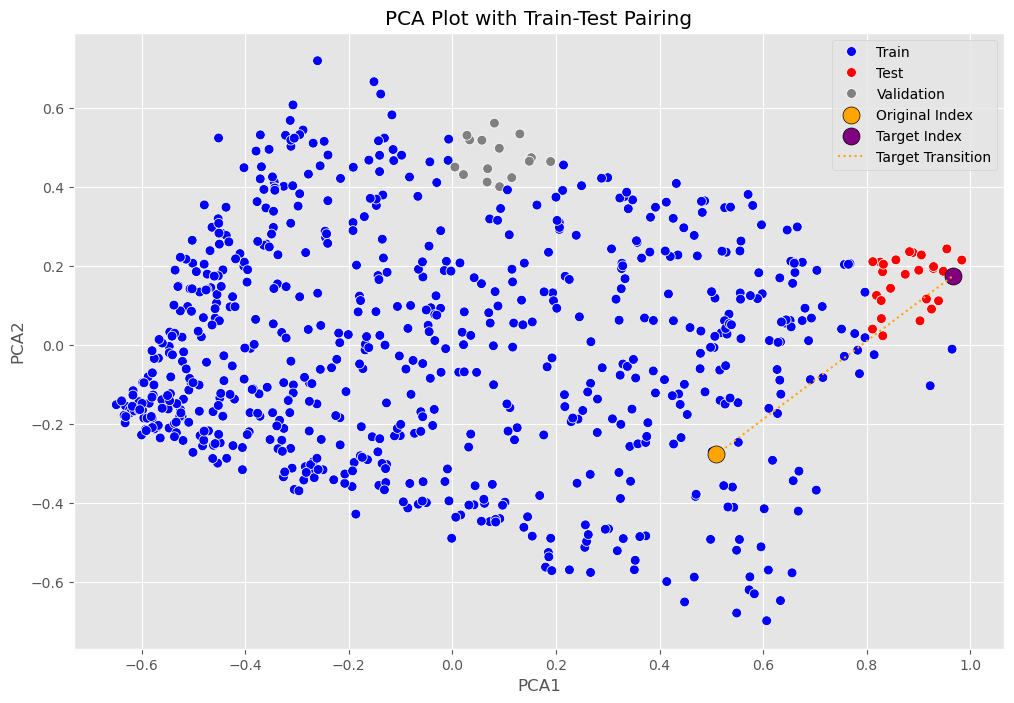

In [17]:
from src.data_transformations.generation_of_supervised_pairs import create_train_val_test_split

(
    X_train,
    y_train,
    X_validation,
    y_validation,
    X_test,
    y_test,
    train_supervised_dataset,
    validation_supervised_dataset,
    test_supervised_dataset,
) = create_train_val_test_split(
    pca_df=mts_pca_df,
    feature_df=feature_df,
    FEATURES_NAMES=FEATURES_NAMES,
    TARGET_NAMES=TARGET_NAMES,
    SEED=SEED,
    output_dir=''
)

We then plot a sample train/test MTS pair. The training instance is the MTS we are in, and the test set is the desired transformation. Be aware that this is plotted in the PCA space.

## Analyzing training set

100%|██████████| 36/36 [00:47<00:00,  1.31s/it]


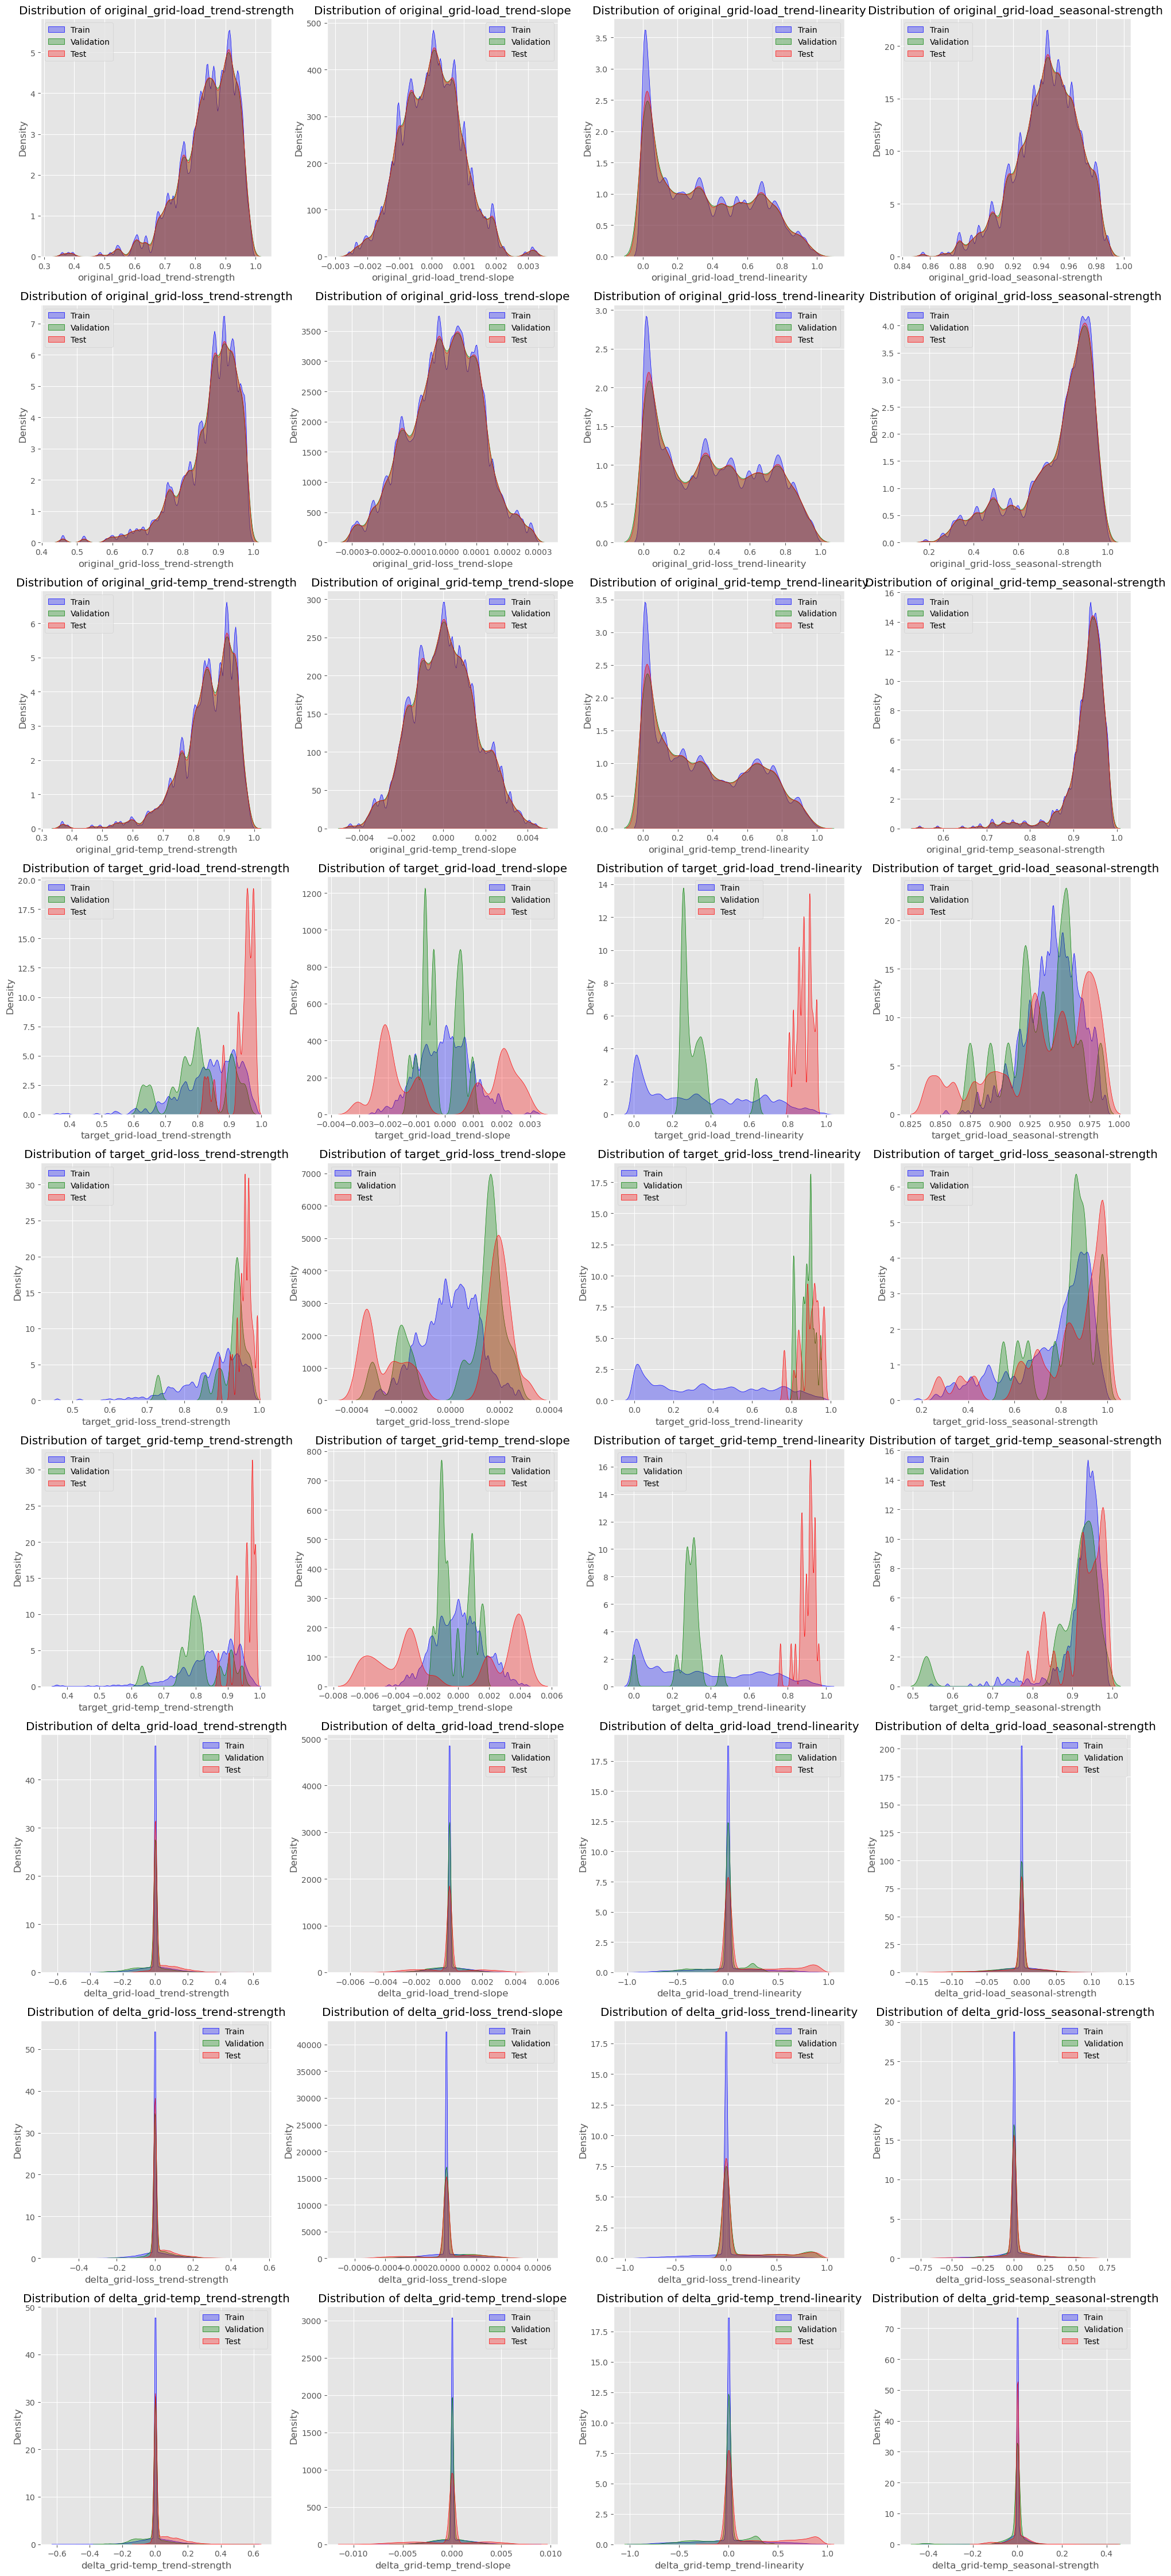

In [18]:
import math
from tqdm import tqdm

columns = [col for col in train_supervised_dataset.columns if col not in ['original_index', 'target_index', 'delta_index']]

# Define grid size
n_cols = 4  # Number of columns in the grid
n_rows = math.ceil(len(columns) / n_cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  
axes = axes.flatten()  # Flatten axes array to easily iterate

# Loop through each column and plot on the grid
for i, col in tqdm(enumerate(columns), total=len(columns)):
    ax = axes[i]
    
    # Plot KDE distributions
    sns.kdeplot(train_supervised_dataset[col], label='Train', color='blue', fill=True, alpha=0.3, ax=ax)
    sns.kdeplot(validation_supervised_dataset[col], label='Validation', color='green', fill=True, alpha=0.3, ax=ax)
    sns.kdeplot(test_supervised_dataset[col], label='Test', color='red', fill=True, alpha=0.3, ax=ax)
    
    # Titles and labels
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend()

# Remove empty subplots (if any)
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])  # Delete extra axes

# Adjust layout
plt.tight_layout()
plt.show()

# Training feed forward feature model.

In [19]:
feature_model_input_size = X_train.shape[1]
feature_model_output_size = y_train.shape[1]

In [20]:
from src.models.feedforward import FeedForwardFeatureModel

feature_model = FeedForwardFeatureModel(
    input_size=feature_model_input_size,
    output_size=feature_model_output_size,
    hidden_network_sizes=feature_model_hidden_network_sizes,
    save_dir='',
    name='feedforward_feature',
    load_model=True
)

INFO:BEAST-logger:Building feedforward forecaster with hidden sizes: [256, 256, 256, 256, 256]
INFO:BEAST-logger:Loading trained model from feedforward_feature.pth...
/Users/vegardsjavik/Uni/Master/Thesis/BEAST/src/models/feedforward.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full 

In [21]:
from src.plots.loss_history import plot_loss_history
from src.utils.model_functions import train_model
import seaborn as sns
from matplotlib import pyplot as plt

train_loss_history, validation_loss_history = train_model(
    model=feature_model,
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation,
    batch_size=feature_model_batch_size,
    num_epochs=feature_model_epochs,
    learning_rate=feature_model_learning_rate,
    early_stopping_patience=feature_model_early_stopping_patience,
    log_wandb=log_training_to_wandb
)
loss_fig = plot_loss_history(
    train_loss_history=train_loss_history,
    validation_loss_history=validation_loss_history,
)
loss_fig.show()

INFO:BEAST-logger:Training model with device: cpu
  0%|          | 0/500 [00:29<?, ?it/s]


KeyboardInterrupt: 

Then we run inference through the logic developed in the correlation model

In [ ]:
from src.utils.data_formatting import use_model_predictions_to_create_dataframe
from src.utils.model_functions import run_model_inference


predictions_validation = run_model_inference(model=feature_model, X_test=X_validation)
# FIXME: The fact that we send the test supervised dataset as an argument is not pretty
predictions_validation = use_model_predictions_to_create_dataframe(
    predictions_validation,
    TARGET_NAMES=TARGET_NAMES,
    target_dataframe=validation_supervised_dataset,
)

predictions_test = run_model_inference(model=feature_model, X_test=X_test)
# FIXME: The fact that we send the test supervised dataset as an argument is not pretty
predictions_test = use_model_predictions_to_create_dataframe(
    predictions_test,
    TARGET_NAMES=TARGET_NAMES,
    target_dataframe=test_supervised_dataset,
)

INFO:BEAST-logger:Running model inference with device: cpu
INFO:BEAST-logger:Running model inference with device: cpu


### Prediction plotting in PCA space
To be able to plot the predictions in PCA space we transform the dataframe into a numpy structure and run PCA on it.

/var/folders/t1/cjrcl1s578gdksfbv787y8x40000gn/T/ipykernel_89770/28195269.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


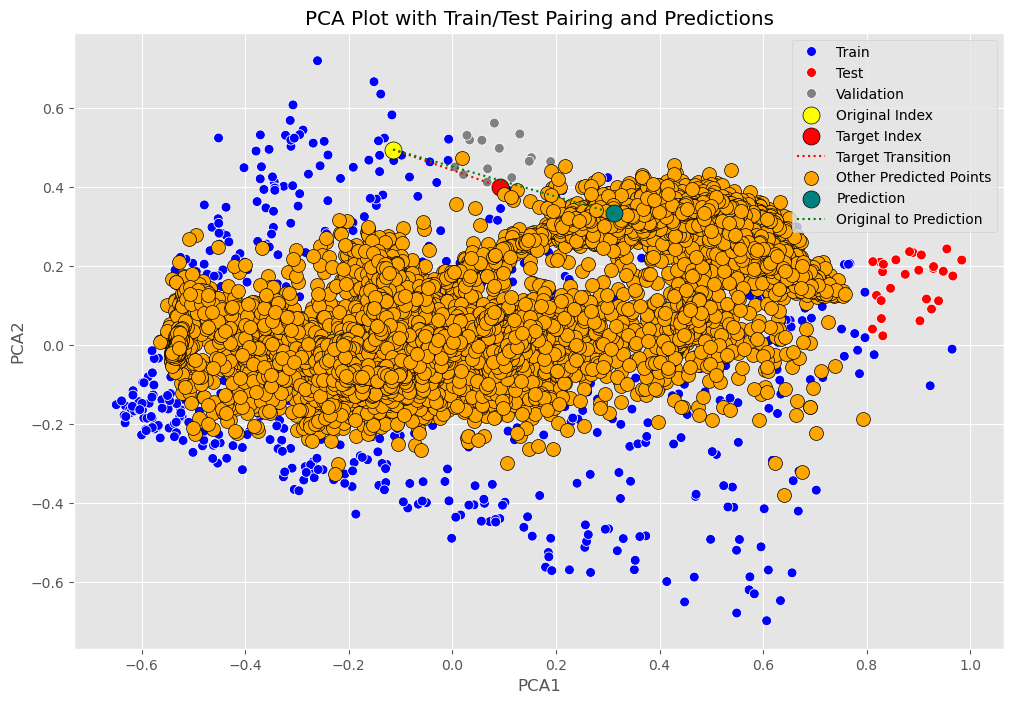

In [ ]:
from src.plots.pca_train_test_pairing import pca_plot_train_test_pairing_with_predictions


predictions_without_index = predictions_validation.drop(columns=["prediction_index"])
predictions_pca = pca_transformer.transform(predictions_without_index)
predictions_validation["pca1"] = predictions_pca["pca1"]
predictions_validation["pca2"] = predictions_pca["pca2"]
prediction = predictions_validation.sample(n=1, random_state=SEED).reset_index(
    drop=True
)
index = prediction["prediction_index"][0]
dataset_row = validation_supervised_dataset.loc[index]
fig = pca_plot_train_test_pairing_with_predictions(
    mts_pca_df, dataset_row, predictions_validation, prediction
)
fig.show()

# Analysis of results

In [ ]:
validation_supervised_dataset.head(3).T

,0,1,2
original_index,0.000000,0.000000,0.000000
original_grid-load_trend-strength,0.862437,0.862437,0.862437
original_grid-load_trend-slope,-0.000562,-0.000562,-0.000562
original_grid-load_trend-linearity,0.185495,0.185495,0.185495
original_grid-load_seasonal-strength,0.944772,0.944772,0.944772
original_grid-loss_trend-strength,0.945474,0.945474,0.945474
original_grid-loss_trend-slope,0.000073,0.000073,0.000073
original_grid-loss_trend-linearity,0.140500,0.140500,0.140500
original_grid-loss_seasonal-strength,0.375897,0.375897,0.375897
original_grid-temp_trend-strength,0.849588,0.849588,0.849588


## Model error analysis
We then look at which features the model does well on, and which it does not do well on. 

In [ ]:
from src.utils.evaluation.feature_space_evaluation import find_error_of_each_feature_for_each_sample


differences_df_validation = find_error_of_each_feature_for_each_sample(
    predictions=predictions_validation,
    labelled_test_dataset=validation_supervised_dataset,
)
differences_df_test = find_error_of_each_feature_for_each_sample(
    predictions=predictions_test, labelled_test_dataset=test_supervised_dataset
)

100%|██████████| 53274/53274 [00:08<00:00, 5988.20it/s]


As we can see, the model seems to struggle most with trend related features. Let's look closer into the cases when the model fails the hardest for these features.

In [ ]:
from src.utils.evaluation.mse import get_mse_for_features_and_overall


overall_mse_validation, mse_values_for_each_feature_validation = (
    get_mse_for_features_and_overall(differences_df_validation)
)
overall_mse_test, mse_values_for_each_feature_test = get_mse_for_features_and_overall(
    differences_df_test
)

print(
    f"Overall MSE for model\nValidation: {overall_mse_validation}\nTest: {overall_mse_test}"
)

INFO:BEAST-logger:Calculating MSE for each feature
INFO:BEAST-logger:Calculating overall MSE
INFO:BEAST-logger:Calculating MSE for each feature
INFO:BEAST-logger:Calculating overall MSE


Overall MSE for model
Validation: 0.027369642345906133
Test: 0.018354638474641465
